UNCASEDでやる

foldを固定して、デフォルトのdrop0.1を学習して、0.3と比較する

batch sizeが小さいので、buckets は shuffleしたほうがいいでしょう

Fine tuniningする！
dropout 0.1する

Tokenize済みのtrainを使う

sentence_dfやる, warm up


# Property
- LSTM
- no annealing
- aux
- Subgroup negative

## pytorch-pretrained-BERT
- import pytorch-pretrained-bert from source in dataset

the source is cloned from [huggingface/pytorch\-pretrained\-BERT: 📖The Big\-&\-Extending\-Repository\-of\-Transformers: Pretrained PyTorch models for Google's BERT, OpenAI GPT & GPT\-2, Google/CMU Transformer\-XL\.](https://github.com/huggingface/pytorch-pretrained-BERT)

- convert tf checkpoints to pytorch model


- feature extraction with BERT like [huggingface/pytorch\-pretrained\-BERT: 📖The Big\-&\-Extending\-Repository\-of\-Transformers: Pretrained PyTorch models for Google's BERT, OpenAI GPT & GPT\-2, Google/CMU Transformer\-XL\.](https://github.com/huggingface/pytorch-pretrained-BERT)

This kernel is based off of [Import functions from Kaggle script](https://www.kaggle.com/rtatman/import-functions-from-kaggle-script)

In [1]:
from datetime import datetime

In [2]:
batch_size = 16
n_seeds = 1
n_splits = 10
n_epochs = 3

RESULT_TXT = f"bert-{datetime.now().strftime('%Y%m%d-%H%M%S')}.txt"
RESULT_PATH = "../models/fine-tune-bert-uncased-drop0.1"

OUT_DROPOUT = 0.1

TRAIN_ON_N_SPLITS = 2

SUBGROUP_NEGATIVE_WEIGHT_COEF = 1

BERT_HIDDEN_SIZE = 768

BERT_MODEL_PATH = 'bert-base-uncased'
BERT_DO_LOWER = 'uncased' in BERT_MODEL_PATH

MAX_LEN = 220

DEBUG = False

if DEBUG:
    DEBUG_DATA_SIZE = 1000
    n_seeds = 1
    n_splits = 10
    n_epochs = 3

In [3]:
RESULT_TXT

'bert-20190506-060401.txt'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sentencefeaturesoov', 'crawl_emb_nocomp.pickle', 'jigsaw-unintended-bias-in-toxicity-classification', 'crawl_emb_processed_lz4.joblib', 'x-train-tokenized', 'crawl_emb_nocomp.joblib', 'crawl_emb_processed.joblib', 'bert-pretrained-models', 'fasttext-crawl-300d-2m', 'jigsaw-x-train-bert-tokenized', 'glove840b300dtxt', 'roov-crawl.pickle']


In [5]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm import tqdm
tqdm.pandas()
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [6]:
if not os.path.exists(RESULT_PATH):
    os.mkdir(RESULT_PATH)

In [7]:
# 9.9G

if DEBUG:
    train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', nrows=DEBUG_DATA_SIZE)
else:
    train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]


In [8]:
if DEBUG:
    sentence_df = pd.read_csv('../input/sentencefeaturesoov/sentence_features.csv', nrows=DEBUG_DATA_SIZE)
else:
    sentence_df = pd.read_csv('../input/sentencefeaturesoov/sentence_features.csv')

In [9]:
sentence_df.head()

,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,26,3,24,1,2,6,0,0,0.115385,0.923077,0.038462,0.076923,0.230769,0.0,0.0
1,29,3,27,3,0,6,0,0,0.103448,0.931034,0.103448,0.000000,0.206897,0.0,0.0
2,19,2,19,1,0,3,0,0,0.105263,1.000000,0.052632,0.000000,0.157895,0.0,0.0
3,19,3,17,0,2,2,0,0,0.157895,0.894737,0.000000,0.105263,0.105263,0.0,0.0
4,9,0,9,0,0,1,0,0,0.000000,1.000000,0.000000,0.000000,0.111111,0.0,0.0


In [10]:
sentence_feature_mat = sentence_df.values
del sentence_df
gc.collect()

0

In [11]:
TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

subgroup_bool_train = train[identity_columns].fillna(0)>=0.5
toxic_bool_train = train[TOXICITY_COLUMN].fillna(0)>=0.5
subgroup_negative_mask = subgroup_bool_train.values.sum(axis=1).astype(bool) & ~toxic_bool_train

sample_weight = np.ones((y_train.shape[0],))
sample_weight += SUBGROUP_NEGATIVE_WEIGHT_COEF * subgroup_negative_mask

del subgroup_bool_train, toxic_bool_train, subgroup_negative_mask
gc.collect()

y_train_torch = torch.tensor(np.concatenate([y_train[:, np.newaxis], y_aux_train, sample_weight[:, np.newaxis]], axis=1), dtype=torch.float32).cuda()

In [12]:

import torch
from pytorch_pretrained_bert import convert_tf_checkpoint_to_pytorch
from pytorch_pretrained_bert import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)


In [13]:
%%time
if BERT_DO_LOWER:
    tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized.csv'
else:
    tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized_cased.csv'
    

if DEBUG:
    df_x_tokenized = pd.read_csv(tokenized_path,
                                 header=None, nrows=DEBUG_DATA_SIZE)
else:
    df_x_tokenized = pd.read_csv(tokenized_path,
                                 header=None)


CPU times: user 5.05 s, sys: 388 ms, total: 5.44 s
Wall time: 8.44 s


In [14]:
df_x_tokenized.head()

,0
0,"[CLS] this is so cool . it ' s like , ' would ..."
1,[CLS] thank you ! ! this would make my life a ...
2,[CLS] this is such an urgent design problem ; ...
3,[CLS] is this something i ' ll be able to inst...
4,[CLS] ha ##ha you guys are a bunch of losers ....


In [15]:
%%time
x_train_tockenized = df_x_tokenized[0].progress_apply(lambda x: x.split())

100%|██████████| 1804874/1804874 [00:13<00:00, 134889.04it/s]

CPU times: user 12.1 s, sys: 1.31 s, total: 13.4 s
Wall time: 13.4 s


In [16]:
del df_x_tokenized
gc.collect()

0

In [17]:
x_train_tockenized.head()

0    [[CLS], this, is, so, cool, ., it, ', s, like,...
1    [[CLS], thank, you, !, !, this, would, make, m...
2    [[CLS], this, is, such, an, urgent, design, pr...
3    [[CLS], is, this, something, i, ', ll, be, abl...
4    [[CLS], ha, ##ha, you, guys, are, a, bunch, of...
Name: 0, dtype: object

In [18]:
%%time
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, do_lower_case=BERT_DO_LOWER, cache_dir='../bert-cache')
x_train_indexed = x_train_tockenized.progress_apply(lambda x: tokenizer.convert_tokens_to_ids(x[:MAX_LEN]))

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpdlvdz2g3
100%|██████████| 231508/231508 [00:00<00:00, 401835.81B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpdlvdz2g3 to cache at ../bert-cache/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for ../bert-cache/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpdlvdz2g3
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ../bert-cache/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526

CPU times: user 26 s, sys: 947 ms, total: 26.9 s
Wall time: 29.7 s


In [19]:
del x_train_tockenized, tokenizer
gc.collect()

0

In [20]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

57802752

In [21]:
import math
class BucketIterator(object):
    def __init__(self, data, label, batch_size, pad_token, shuffle=True,
                length_quantile=0.95):
        self.data = data
        self.label = label
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.pad_token = pad_token
        self.length_quantile = length_quantile
        # i_batch と i_bucketを変換するindex, shuffleならpermuteする
        self.bucket_index = range(self.__len__())
        
        if not self.shuffle:
            self.index_sorted = sorted(range(len(self.data)), key=lambda i: len(self.data[i]))
        
        self.reset_index()
        
    def reset_index(self):
        self.i_batch = 0
        
        if self.shuffle:
            self.index_sorted = sorted(np.random.permutation(len(self.data)), key=lambda i: len(self.data[i]))
            self.bucket_index = np.random.permutation(self.__len__())
            
    
    def __len__(self):
        return len(self.data) // self.batch_size + 1
    
    def __iter__(self):
        return self
    
    def __next__(self):
        try:
            i_bucket = self.bucket_index[self.i_batch]
        except IndexError as e:
            self.reset_index()
            raise StopIteration
            
        index_batch = self.index_sorted[i_bucket * self.batch_size:
                                        (i_bucket + 1) * self.batch_size]
                                   
        raw_batch_data = [self.data[i] for i in index_batch]
        batch_label = self.label[index_batch]
            
        max_len = int(math.ceil(np.quantile([len(x) for x in raw_batch_data], self.length_quantile)))
        segment_id_batch = np.zeros((len(raw_batch_data), max_len))
        padded_batch = []
        input_mask_batch = []
        for sample in raw_batch_data:
            input_mask = [1] * len(sample) + [0] * (max_len - len(sample))
            input_mask_batch.append(input_mask[:max_len])
            
            sample = sample + [self.pad_token for _ in range(max_len - len(sample))]
            padded_batch.append(sample[:max_len])
            
        self.i_batch += 1
            
        return padded_batch, segment_id_batch, input_mask_batch, batch_label, index_batch

In [22]:

class NeuralNet(nn.Module):
    def __init__(self, num_aux_targets, num_sentence_features):
        super(NeuralNet, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_MODEL_PATH, cache_dir='../bert-cache')
        self.dropout = nn.Dropout(OUT_DROPOUT)
        
        self.linear_sentence1 = nn.Linear(num_sentence_features, num_sentence_features)
        
        n_hidden = BERT_HIDDEN_SIZE + num_sentence_features
        self.linear1 = nn.Linear(n_hidden, n_hidden)
        
        self.linear_out = nn.Linear(n_hidden, 1)
        self.linear_aux_out = nn.Linear(n_hidden, num_aux_targets)
        
    def forward(self, x_features, sentence_features):
        
        _, bert_output = self.bert_model(*x_features, output_all_encoded_layers=False)
        
        bert_output = self.dropout(bert_output)
        
        h_sentence = self.linear_sentence1(sentence_features)
        
        h_cat = torch.cat((bert_output, h_sentence), 1)
        
        h_conc_linear1  = F.relu(self.linear1(h_cat))
        
        hidden = h_cat + h_conc_linear1
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

OOF_TRAIN_COL = 'oof_train'
SUBGROUP_AUC_COL = 'subgroup_auc'
BPSN_AUC_COL = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC_COL = 'bnsp_auc'  # stands for background negative, subgroup positive
from sklearn import metrics
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup_col, label_col, oof_col):
    subgroup_examples = df[df[subgroup_col]]
    return compute_auc(subgroup_examples[label_col], subgroup_examples[oof_col])

def compute_bpsn_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup_col] & ~df[label_col]]
    non_subgroup_positive_examples = df[~df[subgroup_col] & df[label_col]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bnsp_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup_col] & df[label_col]]
    non_subgroup_negative_examples = df[~df[subgroup_col] & ~df[label_col]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bias_metrics_for_model(df,
                                   subgroup_list,
                                   oof_col,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    record_list = []
    for subgroup in subgroup_list:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(df[df[subgroup]])
        }
        record[SUBGROUP_AUC_COL] = compute_subgroup_auc(df, subgroup, label_col, oof_col)
        record[BPSN_AUC_COL] = compute_bpsn_auc(df, subgroup, label_col, oof_col)
        record[BNSP_AUC_COL] = compute_bnsp_auc(df, subgroup, label_col, oof_col)
        record_list.append(record)
    return pd.DataFrame(record_list).sort_values('subgroup_auc', ascending=True)

TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC_COL], POWER),
        power_mean(bias_df[BPSN_AUC_COL], POWER),
        power_mean(bias_df[BNSP_AUC_COL], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

def get_various_auc(valid_df, y_pred):
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    valid_df.loc[:, OOF_TRAIN_COL] = y_pred
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, OOF_TRAIN_COL, TOXICITY_COLUMN)
    overall_auc = calculate_overall_auc(valid_df, OOF_TRAIN_COL)
    return get_final_metric(bias_metrics_df, overall_auc), overall_auc, bias_metrics_df

def adjust_lr(optimizer, i_batch, min_lr, max_lr, n_batch_all, warm_up_batch_ratio):
    n_batch_warmed = int(n_batch_all * warm_up_batch_ratio)
    if i_batch > n_batch_warmed:
        optimizer.param_groups[0]['lr'] = max_lr
    else:
        optimizer.param_groups[0]['lr'] = (max_lr - min_lr) / n_batch_warmed * i_batch + min_lr


In [24]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.clock()
        self.old_time = time.clock()
        print('start mearsure elapsed times')
        
    def stamp(self, comment):
        print(comment + f': from start {time.clock() - self.start_time: .1f}, from old {self.old_time - - self.start_time: .1f}')
        self.old_time = time.clock()

In [27]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

57802752

In [28]:
import joblib
from sklearn.preprocessing import StandardScaler

timer = ElapsedTimer()
loss_fn=nn.BCEWithLogitsLoss(reduction='sum')

dev_loss_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_epochs))
val_loss_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_epochs))

auc_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_epochs))

oof_train = np.zeros((n_seeds, n_epochs, len(x_train_indexed)))

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1999)
for i_seed in range(n_seeds):
    print(f'start seed {i_seed}')
    timer.stamp('seed start')
    fold_dev_loss_list = []
    fold_val_loss_list = []
    
    
    for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_indexed)):
        if i_fold == 0:
            continue
        
        if i_fold >= TRAIN_ON_N_SPLITS:
            break
        timer.stamp('epoch start')
            
        
        print(f'start fold {i_fold}')
        print(f'toxic ratio dev: {y_train_torch[dev_index].mean().item()}, val: {y_train_torch[val_index].mean().item()}')
        
        # Load pre-trained model (weights)
        model = NeuralNet(y_aux_train.shape[-1], sentence_feature_mat.shape[-1])
        model.cuda()
        print('model', torch.cuda.memory_allocated())

        optimizer = torch.optim.Adam(model.parameters())
        
        scaler = StandardScaler()
        dev_sentence_feature_mat = scaler.fit_transform(sentence_feature_mat[dev_index])
        val_sentence_feature_mat = scaler.transform(sentence_feature_mat[val_index])
        
        joblib.dump(scaler, os.path.join(RESULT_PATH, f'scaler-seed{i_seed}-fold{i_fold}.joblib'))

        dev_loader = BucketIterator([x_train_indexed[i] for i in dev_index],
                                    torch.cat([y_train_torch[dev_index],
                                               torch.tensor(dev_sentence_feature_mat, dtype=torch.float32).cuda()], dim=1),
                                    batch_size=batch_size, pad_token=0, shuffle=True)
        val_loader = BucketIterator([x_train_indexed[i] for i in val_index],
                                    torch.cat([y_train_torch[val_index],
                                               torch.tensor(val_sentence_feature_mat, dtype=torch.float32).cuda()], dim=1),
                                    batch_size=batch_size, pad_token=0, shuffle=False)
        
        print('loaders', torch.cuda.memory_allocated())
        
        
        all_test_preds = []
        dev_loss_list = []
        val_loss_list = []

        for i_epoch in range(n_epochs):
            timer.stamp(f'i_epoch {i_epoch} start')
            
            print(f'epoch_start: {i_epoch}', torch.cuda.memory_allocated())
            start_time = time.time()
            
            model.train()
            dev_avg_loss = 0.
            for i_batch, batch in enumerate(progress_bar(dev_loader)):
                if i_epoch == 0:
                    adjust_lr(optimizer, i_batch, min_lr=1e-6, max_lr=1e-5,
                              n_batch_all=len(dev_loader), warm_up_batch_ratio=0.1)
                x_batch = batch[0]
                segment_id_batch = batch[1]
                input_mask_batch = batch[2]
                y_batch = batch[3]
                index_batch = batch[4]
                
                y_true_batch = y_batch[:, :1+y_aux_train.shape[-1]]
                sample_weight_batch = y_batch[:, 1+y_aux_train.shape[-1]]
                sentence_feature_batch = y_batch[:, -sentence_feature_mat.shape[-1]:]
                
                x_features = [torch.tensor(feature, dtype=torch.long).cuda() for feature in [x_batch, segment_id_batch, input_mask_batch]]
#                 print('x_features', torch.cuda.memory_allocated())
#                 timer.stamp(f'x_features')
                
                y_pred = model(x_features, sentence_feature_batch)
#                 print('after_prediction', torch.cuda.memory_allocated())
#                 timer.stamp(f'after_prediction')
                
                del x_features
                torch.cuda.empty_cache()
#                 print('torch.cuda.empty_cache()', torch.cuda.memory_allocated())
                
                
                loss_fn = nn.BCEWithLogitsLoss(sample_weight_batch[:, None], reduction='sum')
                loss = loss_fn(y_pred, y_true_batch) # last one is a sample weight

                optimizer.zero_grad()
                loss.backward()
#                 print('loss.backward()', torch.cuda.memory_allocated())

                optimizer.step()
                dev_avg_loss += loss.item() / dev_index.shape[0]
                
                
                del y_pred, loss
                torch.cuda.empty_cache()
#                 print('del y_pred', torch.cuda.memory_allocated())
            
            optimizer.zero_grad()
            timer.stamp(f'after dev all batch')
            gc.collect()
            torch.cuda.empty_cache()
            print('after dev loop', torch.cuda.memory_allocated())
            timer.stamp(f'after all batch gc.collect()')
            
            dev_loss_array[i_seed, i_fold, i_epoch] = dev_avg_loss

            model.eval()
            val_avg_loss = 0.
            epoch_val_pred = np.zeros(val_index.shape[0])
            for batch in progress_bar(val_loader):
                x_batch = batch[0]
                segment_id_batch = batch[1]
                input_mask_batch = batch[2]
                y_batch = batch[3]
                index_batch = batch[4]
                
                y_true_batch = y_batch[:, :1+y_aux_train.shape[-1]]
                sample_weight_batch = y_batch[:, 1+y_aux_train.shape[-1]]
                sentence_feature_batch = y_batch[:, -sentence_feature_mat.shape[-1]:]
                
                x_features = [torch.tensor(feature, dtype=torch.long).cuda() for feature in [x_batch, segment_id_batch, input_mask_batch]]
#                 print('x_features', torch.cuda.memory_allocated())
#                 timer.stamp(f'x_features')
                
                y_pred = model(x_features, sentence_feature_batch)
                
#                 print('after_prediction', torch.cuda.memory_allocated())
#                 timer.stamp(f'after_prediction')
                
                del x_features
                torch.cuda.empty_cache()
#                 print('torch.cuda.empty_cache()', torch.cuda.memory_allocated())
                                
                loss_fn = nn.BCEWithLogitsLoss(sample_weight_batch[:, None], reduction='sum')
                loss = loss_fn(y_pred, y_true_batch) # last one is a sample weight

                val_avg_loss += loss.item() / val_index.shape[0]
                
                epoch_val_pred[index_batch] = sigmoid(y_pred[:, 0].detach().cpu().numpy())
                
                del y_pred, loss
                torch.cuda.empty_cache()
#                 print('del x_cat, y_pred', torch.cuda.memory_allocated())
            
            timer.stamp(f'after val all batch')

            torch.save(model.state_dict(), os.path.join(RESULT_PATH, 
                f'seed{i_seed}-fold{i_fold}-epoch{i_epoch}.torchModelState'))
            
            timer.stamp(f'after model save')

            val_loss_array[i_seed, i_fold, i_epoch] = val_avg_loss
            
            
            oof_train[i_seed, i_epoch, val_index] = epoch_val_pred

            gc.collect()
            timer.stamp(f'after gc.collect')

            
            valid_df = train.iloc[val_index]
            weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, epoch_val_pred)
            auc_array[i_seed, i_fold, i_epoch] = weighted_auc
            del valid_df
            gc.collect()
            
            timer.stamp(f'after gc.collect')

            np.save(os.path.join(RESULT_PATH, 'oof_train.npy'), oof_train)
            
            elapsed_time = time.time() - start_time
            print(f'Finished epoch {i_epoch} in {elapsed_time: .0f}, dev_loss: {dev_avg_loss:.4f}, val_loss: {val_avg_loss:.4f}' + \
                     f', weighted_auc: {weighted_auc}, overall_auc: {overall_auc} ',
                  file=open(os.path.join(RESULT_PATH, RESULT_TXT), 'a'))
        
        timer.stamp(f'after all folds')
        
        fold_dev_loss_list.append(dev_loss_list)
        fold_val_loss_list.append(val_loss_list)
        del dev_loader, val_loader, model, epoch_val_pred, optimizer
        gc.collect()
        torch.cuda.empty_cache()
        
        timer.stamp(f'after all folds, gc collect')

start mearsure elapsed times
start seed 0
seed start: from start  0.0, from old  163.5
epoch start: from start  0.2, from old  163.6
start fold 1
toxic ratio dev: 0.17373737692832947, val: 0.1741420030593872


INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to /tmp/tmpxwszav88
100%|██████████| 407873900/407873900 [05:19<00:00, 1276076.49B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpxwszav88 to cache at ../bert-cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for ../bert-cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpxwszav88
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../bert-cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e

model 498465792
loaders 664665088
i_epoch 0 start: from start  109.8, from old  163.7
epoch_start: 0 664665088


after dev all batch: from start  17604.8, from old  273.3
after dev loop 1989224960
after all batch gc.collect(): from start  17607.0, from old  17768.4


after val all batch: from start  18383.0, from old  17770.5
after model save: from start  18383.3, from old  18546.6
after gc.collect: from start  18385.4, from old  18546.9
after gc.collect: from start  18398.1, from old  18548.9
i_epoch 1 start: from start  18398.1, from old  18561.6
epoch_start: 1 1989224448


after dev all batch: from start  35902.0, from old  18561.7
after dev loop 1989224960
after all batch gc.collect(): from start  35904.1, from old  36065.5


after val all batch: from start  36681.0, from old  36067.6
after model save: from start  36681.5, from old  36844.5
after gc.collect: from start  36683.7, from old  36845.1
after gc.collect: from start  36690.7, from old  36847.3
i_epoch 2 start: from start  36690.7, from old  36854.3
epoch_start: 2 1989224448


after dev all batch: from start  54200.4, from old  36854.3
after dev loop 1989224960
after all batch gc.collect(): from start  54202.6, from old  54363.9


after val all batch: from start  54979.4, from old  54366.1
after model save: from start  54980.1, from old  55143.0
after gc.collect: from start  54982.4, from old  55143.6
after gc.collect: from start  54989.7, from old  55145.9
after all folds: from start  54989.7, from old  55153.2
after all folds, gc collect: from start  54992.1, from old  55153.2


In [29]:
len(x_batch)

8

In [30]:
dev_loss_array.shape

(1, 2, 3)

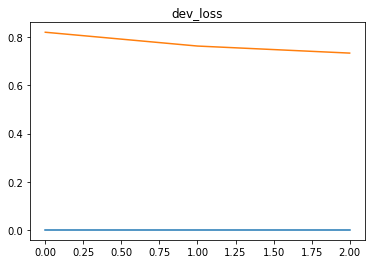

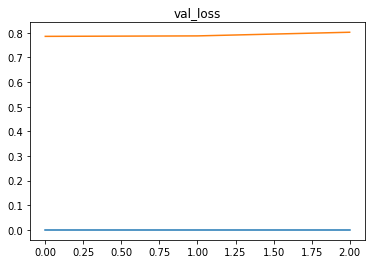

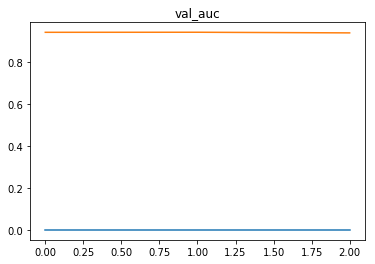

In [31]:
N_FOLDS_TRAINED = 2
plt.figure()
plt.title('dev_loss')
for i_seed in range(n_seeds):
    for dev_loss in dev_loss_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), dev_loss)

plt.figure()
plt.title('val_loss')
for i_seed in range(n_seeds):
    for loss in val_loss_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), loss)
        
plt.figure()
plt.title('val_auc')
for i_seed in range(n_seeds):
    for loss in auc_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), loss)

In [32]:
valid_index_list = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1999)
for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_indexed)):
    if i_fold >= 2:
        break
    
    valid_index_list.append(val_index)
    

In [37]:
oof_train = np.load(os.path.join(RESULT_PATH, 'oof_train.npy'))

In [38]:
oof_train += np.load(os.path.join(RESULT_PATH, 'oof_train_fold0.npy'))

In [39]:
oof_train.shape

(1, 3, 1804874)

In [40]:
if DEBUG:
    valid_df = train.iloc[:DEBUG_DATA_SIZE]
else:
    valid_df = train
from IPython.display import display

valid_index = np.concatenate(valid_index_list)

valid_df = valid_df.iloc[valid_index]
oof_train = oof_train[:, :, valid_index]

def last_n_ensemble(start_epoch, end_epoch=n_epochs):
    print()
    print(f'last {n_epochs - start_epoch}')
    weighted_auc_list = []
    for oof_seed in oof_train:
        oof_last = np.mean(oof_seed[start_epoch:end_epoch], axis=0)
        weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_last)
        weighted_auc_list.append(weighted_auc)
    print(f'weighted auc: mean: {np.mean(weighted_auc_list): 0.4f}, std: {np.std(weighted_auc_list): 0.4f}')
    print(f'overall auc: mean: {np.mean(overall_auc): 0.4f}, std: {np.std(overall_auc): 0.4f}')
    return np.mean(weighted_auc_list)

best_auc = 0
for start_epoch in range(n_epochs):
    w_auc = last_n_ensemble(start_epoch)
    if w_auc > best_auc:
        best_auc = w_auc
        best_epoch = start_epoch
    gc.collect()

print('\n Searched for best start epoch.')
print(f'Best start epoch: {best_epoch}, Best weighted auc: {best_auc}')

best_start_epoch = best_epoch
best_auc = 0
best_end_epoch = best_start_epoch + 1
for end_epoch in range(best_start_epoch+1, n_epochs):
    w_auc = last_n_ensemble(best_start_epoch, end_epoch)
    if w_auc > best_auc:
        best_auc = w_auc
        best_end_epoch = end_epoch
    gc.collect()
    
print('\n Searched for best end epoch.')
print(f'Best end epoch: {best_end_epoch}, Best weighted auc: {best_auc}')


last 3
weighted auc: mean:  0.9415, std:  0.0000
overall auc: mean:  0.9729, std:  0.0000

last 2
weighted auc: mean:  0.9400, std:  0.0000
overall auc: mean:  0.9720, std:  0.0000

last 1
weighted auc: mean:  0.9355, std:  0.0000
overall auc: mean:  0.9699, std:  0.0000

 Searched for best start epoch.
Best start epoch: 0, Best weighted auc: 0.9415273703455507

last 3
weighted auc: mean:  0.9382, std:  0.0000
overall auc: mean:  0.9715, std:  0.0000

last 3
weighted auc: mean:  0.9414, std:  0.0000
overall auc: mean:  0.9727, std:  0.0000

 Searched for best end epoch.
Best end epoch: 2, Best weighted auc: 0.9414150952729043
